# Unsupervised learning

> ## ❓Questions
> - What is unsupervised learning?
> - How can we implement unsupervised learning techniques in python?

> ## ☑︎ Objectives
> - To understand the difference between unsupervised and supervised learning
> - To apply unsupervised methods such as k-means clustering, heirarchical clustering, PCA and t-SNE to data.

## What is unsupervised learning?

Unsupervised learning is a type of machine learning where the algorithm is trained on data that doesn't have labeled outcomes or predefined categories. Unlike supervised learning, which uses labeled datasets to train models to predict specific outcomes, unsupervised learning works with data that only includes inputs without corresponding output labels.

In this module we'll explore two key aspects of unsupervised learning:

1. Clustering: This involves grouping similar data points together based on their features. Common clustering algorithms include K-means and hierarchical clustering.

2. Dimensionality Reduction: This technique aims to reduce the number of features or dimensions in the data while preserving its essential structure. Methods like Principal Component Analysis (PCA) and t-Distributed Stochastic Neighbor Embedding (t-SNE) are used to simplify data into uncorrelated lower dimensions.


## The Iris Dataset

The Iris dataset was created by the British biologist and statistician Sir Ronald A. Fisher in 1936. It consists of a set of observations of iris flowers, with each observation representing a different flower. The dataset includes four features:

1. Sepal Length: Length of the sepal in centimeters.
2. Sepal Width: Width of the sepal in centimeters.
3. Petal Length: Length of the petal in centimeters.
4. Petal Width: Width of the petal in centimeters.

Each observation is labeled with one of three species of iris: 'setosa', 'versicolor', or 'virginica'.

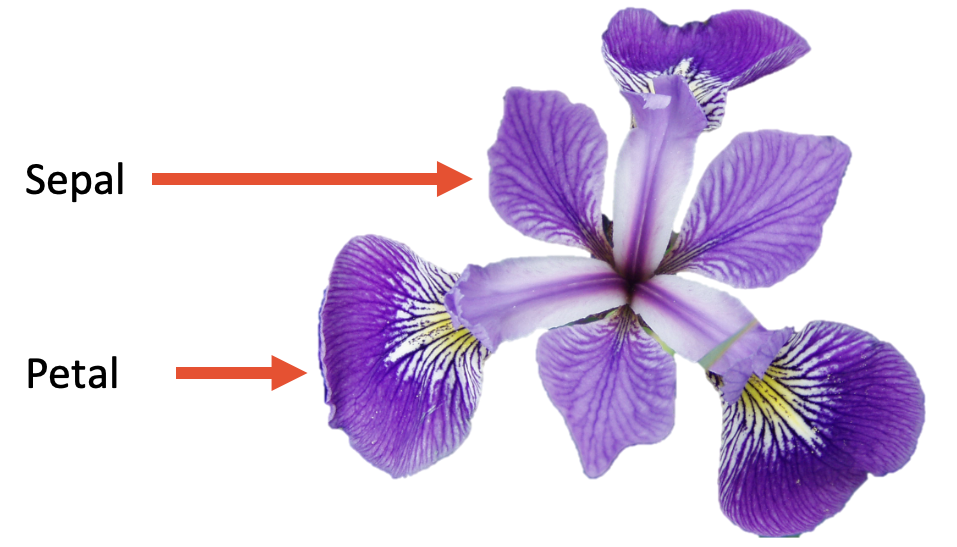

Lets start exploring the Iris dataset. Most of the code is provided for you, but you'll have to fill in some parts: these parts will be indicated with either ... or ____.

First lets import the python packages we'll be using for this module.

In [1]:
# Disable some warnings produced by pandas etc.
# (Don't do this in your actual analyses as you may miss important warnings)
import warnings
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter('ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.utils import resample


# Set up plotting options for seaborn and matplotlib
sns.set_context('notebook')
sns.set_style('ticks')
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

## Dataset
Load the Iris dataset. We will see that this data set has species labels. What if we didn't know we had three species? Could still we use the morphological data to study to distinguish between the species?

In [2]:
iris = sns.load_dataset('iris')

Examine the first 5 entries of the dataset with `pd.head()`

In [3]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


What is its `shape`?

In [4]:
iris.shape

(150, 5)

How many `unique` species are there in the dataset?

In [6]:
iris['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

The first four columns are the measurments and the last column is the species. Split these into separate variables.

In [5]:
iris_features = iris.iloc[:, 0:4]
iris_target = iris.iloc[:,4]
print(iris_features.head())

   sepal_length  sepal_width  petal_length  petal_width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2


Plot 'petal_length' vs 'sepal_width' for each species.

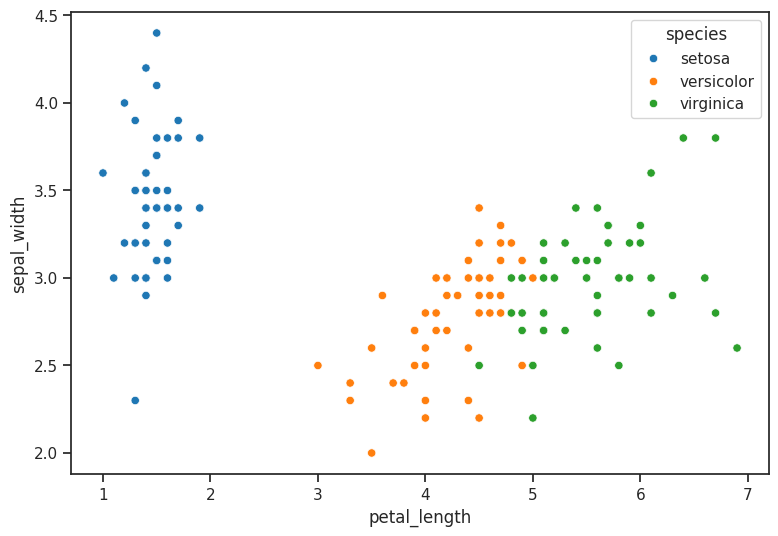

In [ ]:
sns.scatterplot(x='petal_length',
                y='sepal_width',
                data=iris,
                hue=iris_target);

> ### ⚠️ Challenge 1
> Take a few moments to explore the Iris dataset.
> What can you learn? Which species do you think
> will be easier to separate?

In [ ]:
# You can try making plots of other variables in this cell.

## K-means clustering
K-means looks for a fixed number (k) of clusters in a dataset. The K-means algorithm:

- identifies k number of centroids
- allocates every data point to the nearest cluster, while keeping the centroids as small as possible.
- performs iterative (repetitive) calculations to optimize the positions of the centroids

### Scale data

First we need to scale the continuous data int `iris_features` dataset so that the featrues have the same mean and standard deviation.

In [7]:
iris_features_sc = RobustScaler().fit_transform(iris_features)

### Try 2 clusters

In [18]:
model_kmeans_k2 = KMeans(n_clusters=2, random_state=42)
labels_k2 = model_kmeans_k2.fit_predict(iris_features_sc)

Plot the dataframe that is split into two clusters. If we didn't know we had three species, what would we think if we only saw this graph?

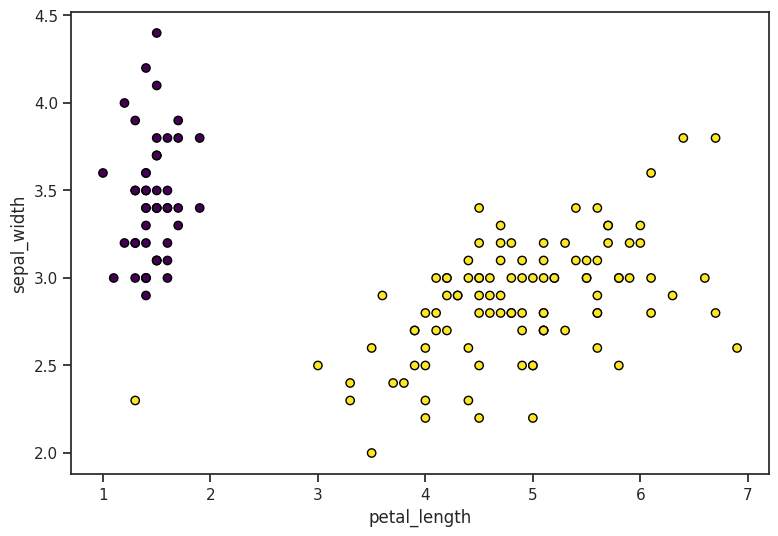

In [19]:
plt.scatter(iris['petal_length'], iris['sepal_width'], c=labels_k2, cmap='viridis', edgecolor='k')
plt.xlabel('petal_length')
plt.ylabel('sepal_width');

### Try 3 clusters

In [14]:
model_kmeans_k3 = KMeans(n_clusters=3, random_state=42)
labels_k3 = model_kmeans_k3.fit_predict(iris_features_sc)
# [x[:2] for x in iris['species'].to_list()]

Plot the dataframe split into 3 clusters.

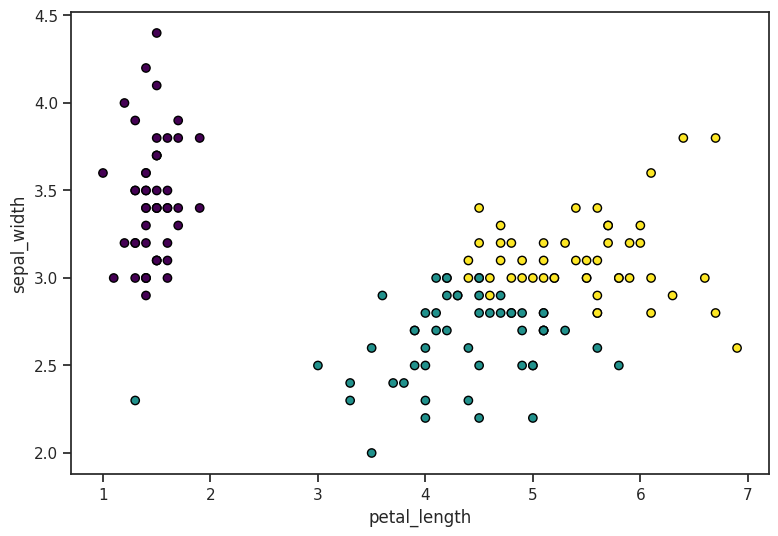

In [15]:
plt.scatter(iris['petal_length'], iris['sepal_width'], c=labels_k3, cmap='viridis', edgecolor='k')
plt.xlabel('petal_length')
plt.ylabel('sepal_width');

> ### ⚠️ Challenge 2  
> Choose whichever clustering approach you think worked best
> among the above. If you partition the data this way, which
> of the variables is most distinct in the clusters?

<details>
    <summary>Solution</summary>
        
```python
iris_clustered = iris.copy()
iris_clustered['prediction'] = labels_k3
iris_clustered.melt(id_vars=['prediction', 'species']) \
              .groupby(['prediction','variable']) \
              .mean('value')
```
</details>

In [24]:
# Use this cell to explore the data.

### Optimal number of clusters
One of the trickier tasks in clustering is identifying the appropriate number of clusters k. We will examine the [Silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) and the Sum-squared distance (Sum of squared distances of samples to their closest cluster center) for a range of `n_clusters`.

In [21]:
from scipy.spatial.distance import cdist

k_range = np.arange(2,12)
silhouette_avgs = []
sum_squared_distances = []

for i, k in enumerate(k_range):
    model_kmeans = KMeans(n_clusters=k, random_state=42)
    label_kmeans = model_kmeans.fit_predict(iris_features_sc)
    silhouette_avgs.append(silhouette_score(iris_features_sc, label_kmeans))
    sum_squared_distances.append(model_kmeans.inertia_)

First we plot the Sihhouette scores.

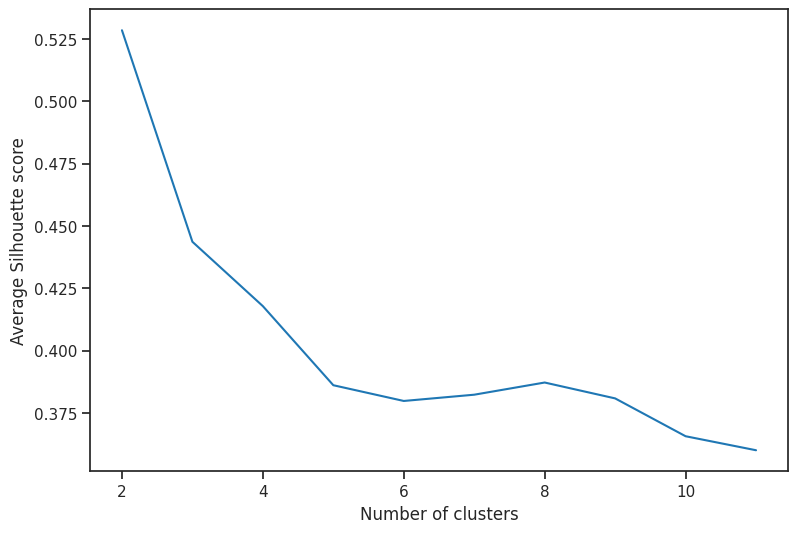

In [22]:
# Look for maximum
plt.plot(k_range, silhouette_avgs)
plt.ylabel('Average Silhouette score')
plt.xlabel('Number of clusters');

And next we plot the Sum-squared distances. This is known as a Scree plot - which plots the Within Cluster Sum of Squared Distances as a function of the number of clusters. The 'elbow' is the point the rate of decrease sharply slows down and the plot starts to level off. This indicates the point at which adding clusters does not significantly decrease the variance within each cluster.

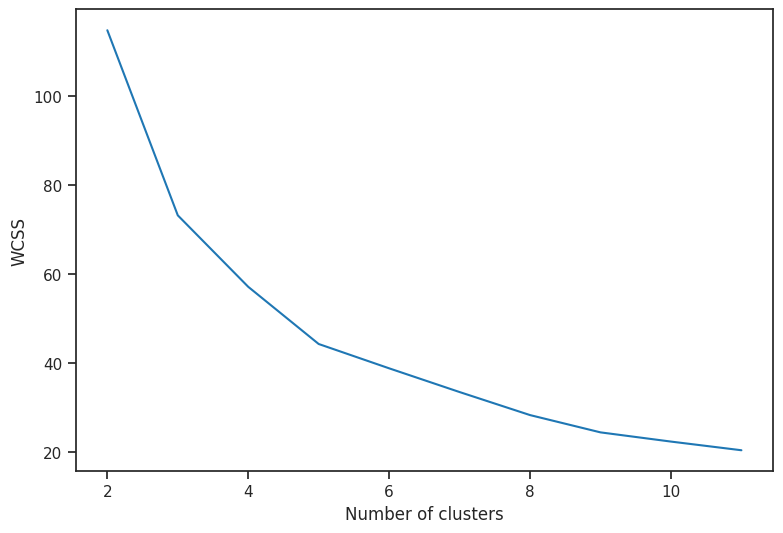

In [23]:
# look for elbow. Also known as Scree plot
plt.plot(k_range, sum_squared_distances)
plt.ylabel('WCSS') #within cluster sum of squared distances
plt.xlabel('Number of clusters');

> ### ⚠️ Challenge
>Most of the methods we tried above tell us that k = 2 appears to be optimal >for the current data set, but we know we have three species. What might this >tell us about our species? How can we proceed from here?
<details>
    <summary>Solution</summary>
This indicates that some of our species are not easy to distinguish i.e. they are very similar based on the observations we have. We could try to get more data (if possible) or try other clustering methods.
</details>

## Hierarchical Clustering

Hierarchical clustering is a method of cluster analysis that seeks to build a hierarchy of clusters. It creates a tree-like structure called a dendrogram, which shows the arrangement of clusters at various levels of similarity or distance.

The first step is to compute the distance between each sample. We use the [linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage) function to compute the distances and we will use the 'ward' distance.

In [29]:
# Use the scaled version of iris features.
linked = linkage(iris_features_sc, method='ward')

We can plot a dendrogram displaying the arrangement of clusters at various levels of similarity.

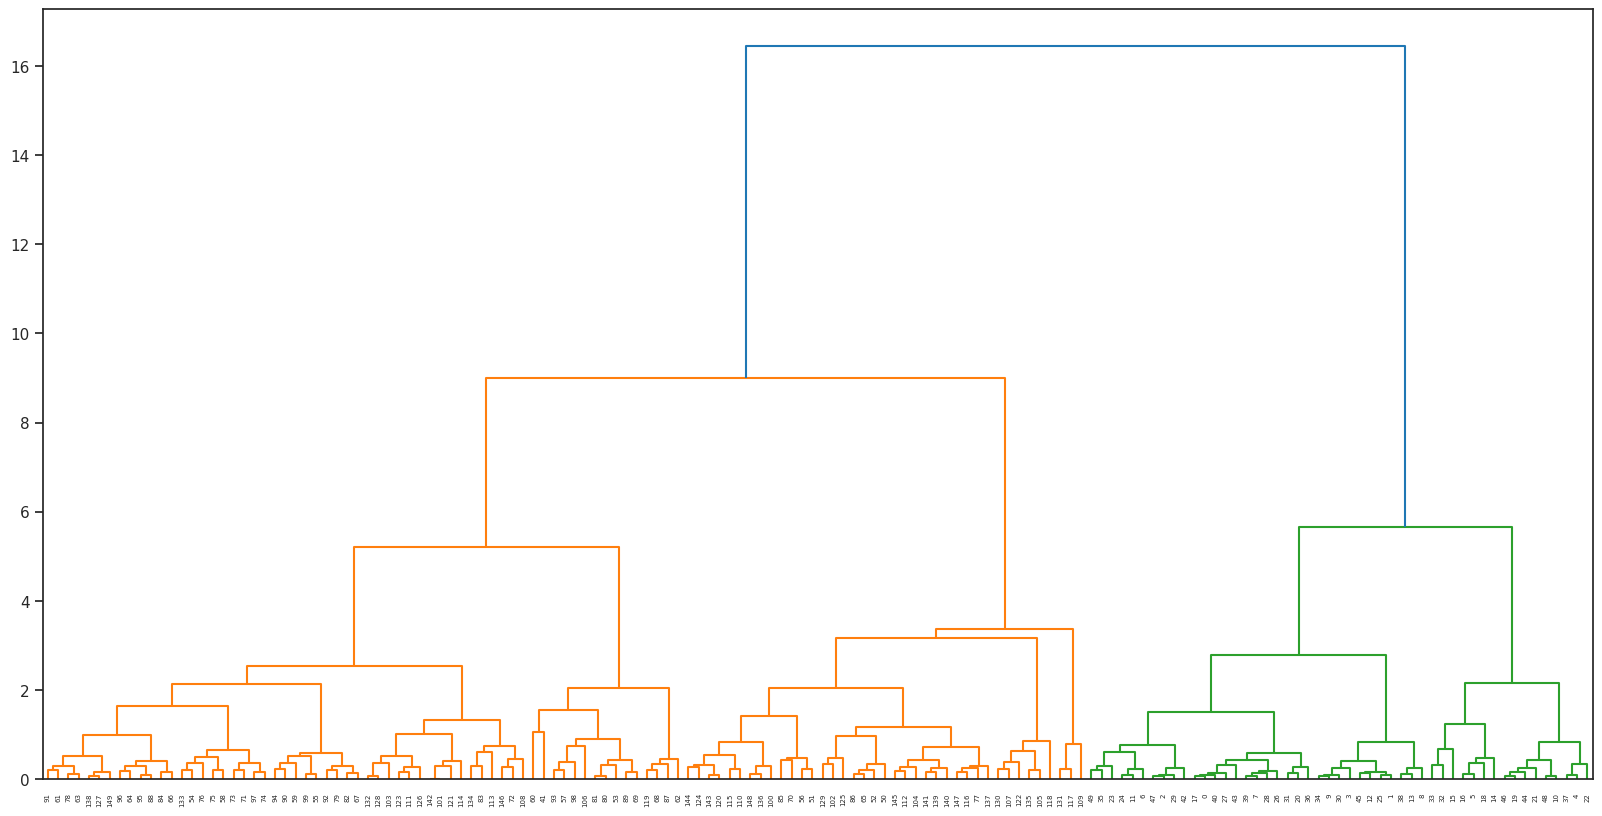

In [30]:
f = plt.figure(figsize=(20, 10))
dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=True
)
plt.show();

We can also use the `AgglomerativeClustering` package from `scikit-learn` to perform heirachical clustering and cut the dendogram in a specified number of clusters `n_clusters`.

In [31]:
# Split the data into 3 clusters.
model_hclust = AgglomerativeClustering(n_clusters=3, linkage='ward')
iris_hc = model_hclust.fit(iris_features_sc)

Now lets plot the petal length against the sepal width split into our 3 clusters.

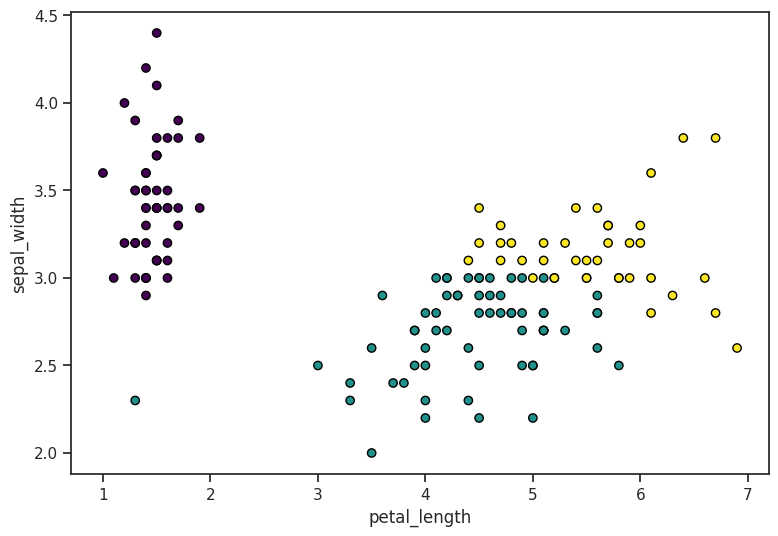

In [32]:
plt.scatter(iris['petal_length'], iris['sepal_width'],
            c=model_hclust.labels_,
            cmap='viridis',
            edgecolor='k')
plt.xlabel('petal_length')
plt.ylabel('sepal_width')

What does the above graph tell us about our data? Does it give a similar result to the prior k-means analysis?

### Plotting data

Another way of visualising clustering is through a heatmap.

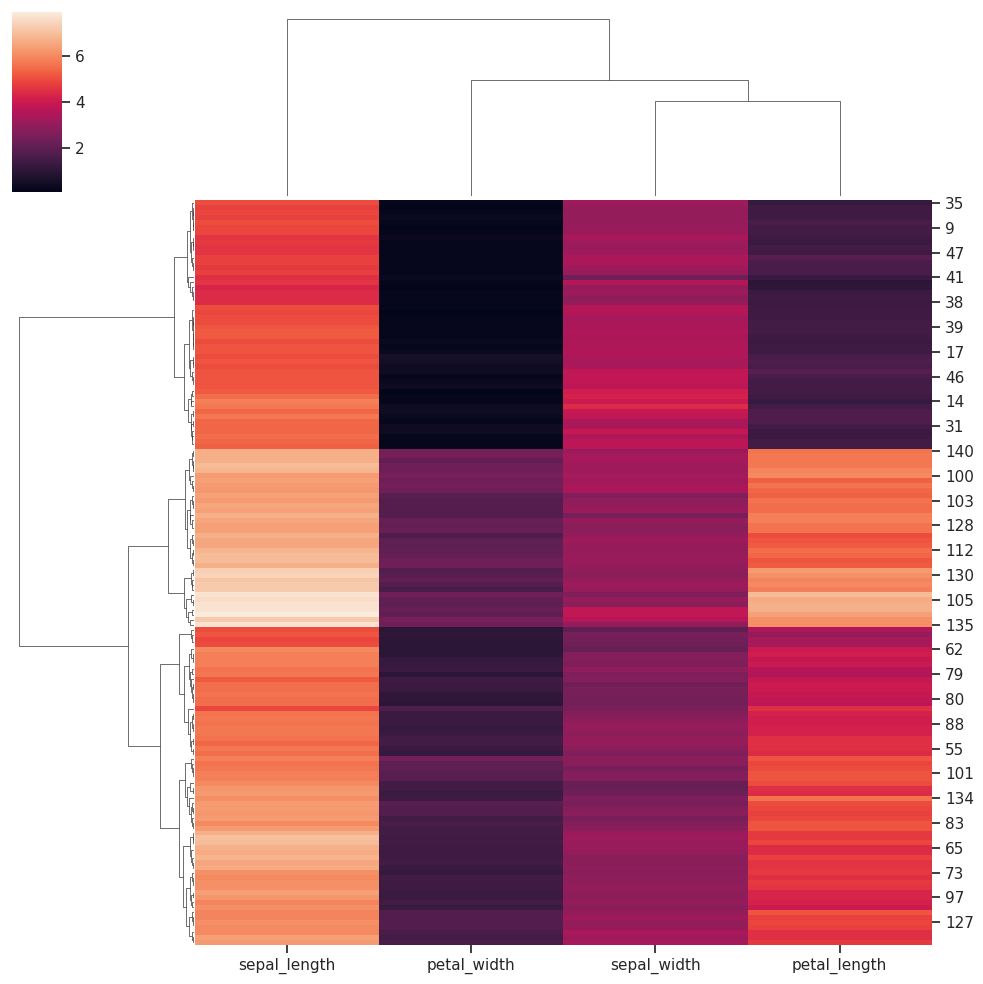

In [34]:
sns.clustermap(iris_features, method='ward')

> ### ⚠️ Challenge
>Try constructing a heatmap using another linkage method (e.g. 'single', see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) for a description of the linkage methods), and visualise the results. Do you think your approach is better or worse than 'ward' linkage?
<details>
    <summary>Solution</summary>

```python
sns.clustermap(iris_features, method='single')
```
</details>

## Principal Component Analysis (PCA)

In [ ]:
nPCs = 3
PCnames = ['PC1','PC2','PC3']
iris_pca = PCA(n_components=nPCs)
iris_reduced = iris_pca.fit_transform(iris_features)

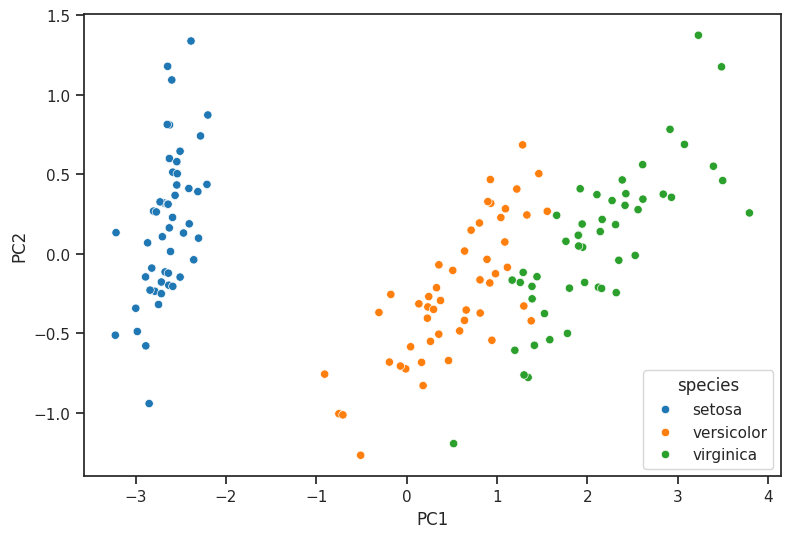

In [ ]:
iris_PC_df = pd.DataFrame(iris_reduced, columns = PCnames)
sns.scatterplot(x='PC1',y='PC2', data=iris_PC_df, hue=iris_target);

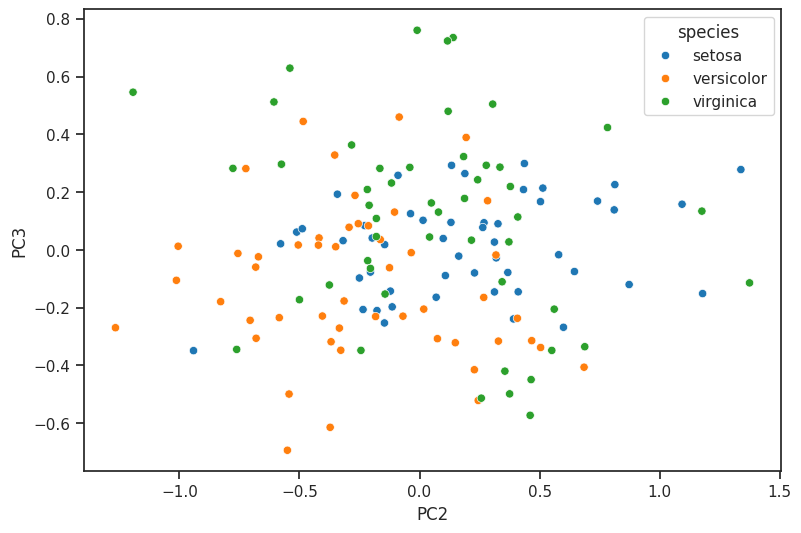

In [ ]:
sns.scatterplot(x='PC2', y='PC3', data=iris_PC_df, hue=iris_target);

### Eigenvalues

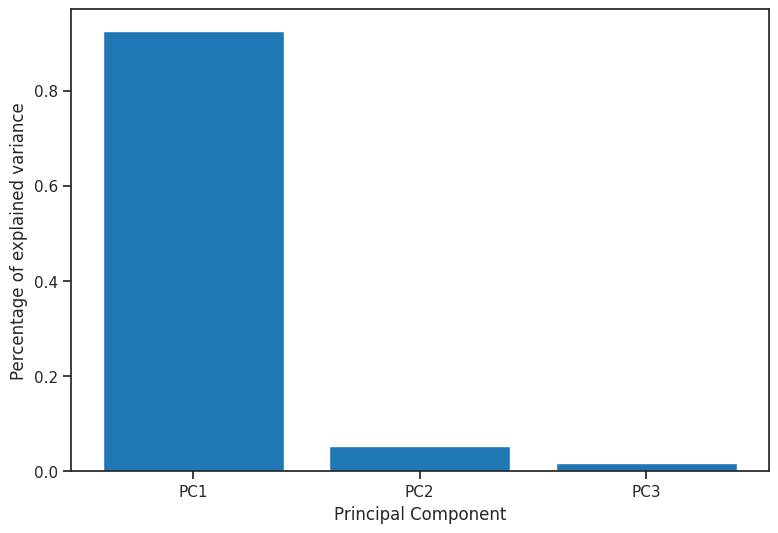

In [ ]:
iris_eig = iris_pca.explained_variance_ratio_

x = np.arange(nPCs)
fig, ax = plt.subplots()
plt.bar(x, iris_eig)
plt.ylabel('Percentage of explained variance')
plt.xlabel('Principal Component')
plt.xticks(x, PCnames);

In [ ]:
iris_comp = iris_pca.components_
iris_comp

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102],
       [-0.58202985,  0.59791083,  0.07623608,  0.54583143]])

In [ ]:
df_iris_comp = pd.DataFrame(iris_comp, columns=iris.columns.drop('species'), index=PCnames)
df_iris_comp

,sepal_length,sepal_width,petal_length,petal_width
PC1,0.361387,-0.084523,0.856671,0.358289
PC2,0.656589,0.730161,-0.173373,-0.075481
PC3,-0.582030,0.597911,0.076236,0.545831


In [ ]:
df_iris_comp.T

,PC1,PC2,PC3
sepal_length,0.361387,0.656589,-0.582030
sepal_width,-0.084523,0.730161,0.597911
petal_length,0.856671,-0.173373,0.076236
petal_width,0.358289,-0.075481,0.545831


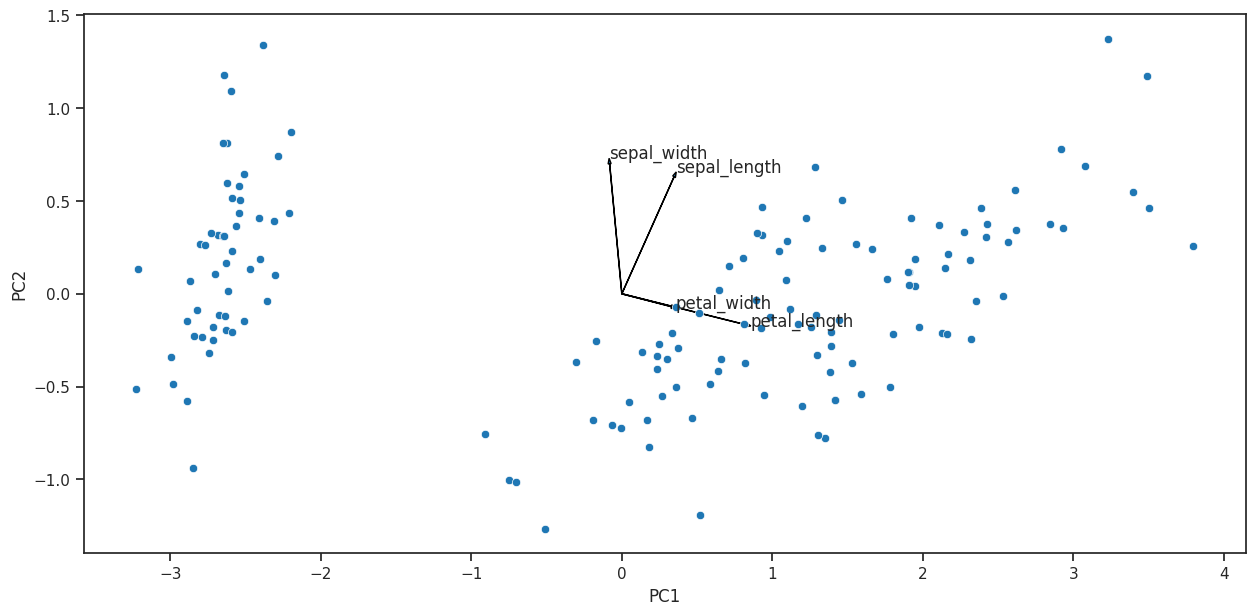

In [ ]:
f = plt.figure(figsize=(15, 7))
ax = plt.axes()
for idx in range(df_iris_comp.T.index.shape[0]):
    ax.arrow(
        0, 0,
        df_iris_comp.T['PC1'][idx],
        df_iris_comp.T['PC2'][idx],
        head_width=0.02, ec='k',
        length_includes_head=True,
    )
    ax.annotate(df_iris_comp.columns[idx],
                xy=(df_iris_comp.T['PC1'][idx],
                    df_iris_comp.T['PC2'][idx]))
sns.scatterplot(x='PC1', y='PC2', data=iris_PC_df);

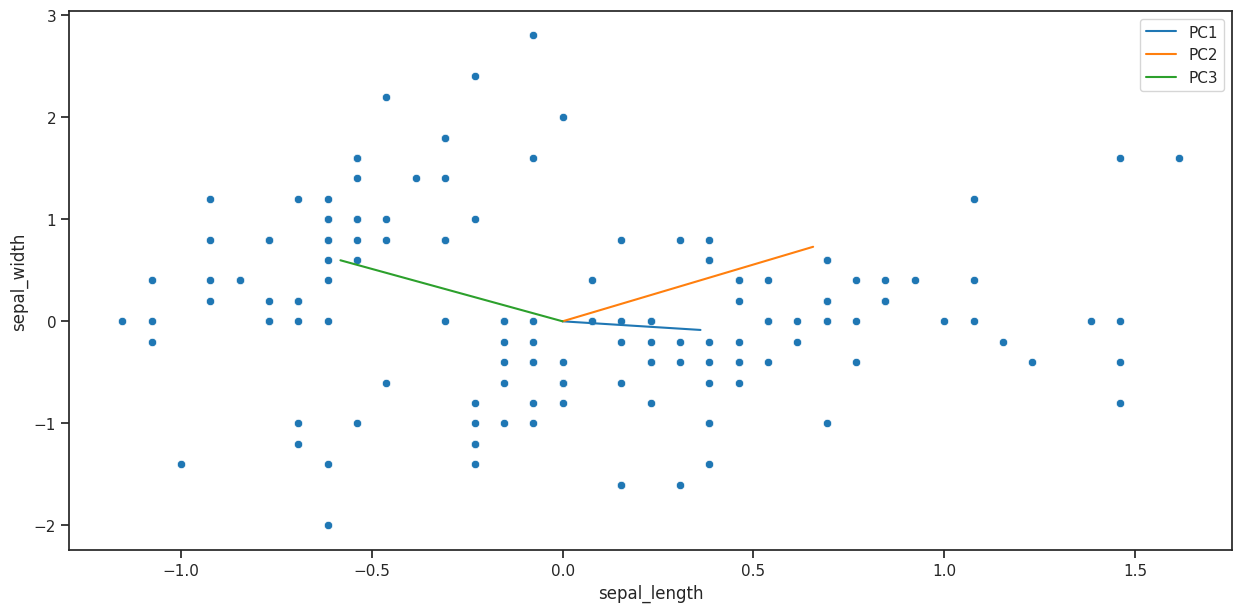

In [ ]:
iris_scaled = pd.DataFrame(iris_features_sc, columns=iris_features.columns)

f = plt.figure(figsize=(15, 7))

for pc in np.arange(nPCs):
    plt.plot([0, iris_comp[pc, 0]], [0,iris_comp[pc,1]],
             label=PCnames[pc])
plt.xlabel(iris_features.columns[0])
plt.ylabel(iris_features.columns[1])
sns.scatterplot(x='sepal_length', y='sepal_width', data=iris_scaled)
plt.legend();

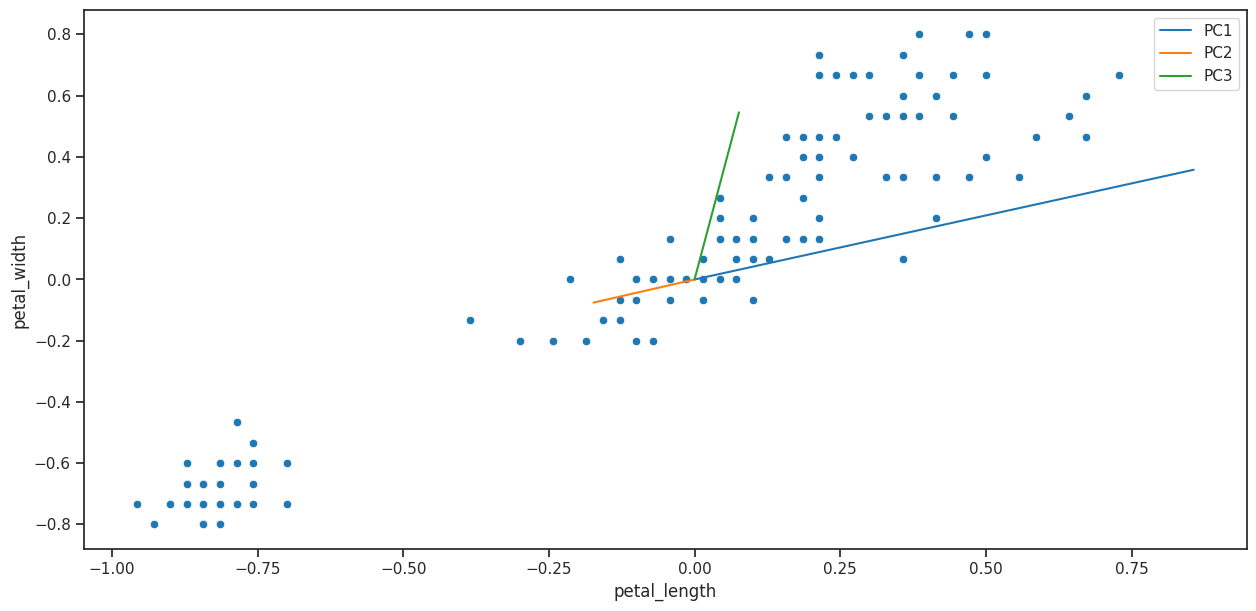

In [ ]:
f = plt.figure(figsize=(15, 7))

for pc in np.arange(nPCs):
    plt.plot([0,iris_comp[pc,2]], [0,iris_comp[pc,3]], label=PCnames[pc])
plt.xlabel(iris_features.columns[2])
plt.ylabel(iris_features.columns[3])
sns.scatterplot(x='petal_length', y='petal_width', data=iris_scaled)
plt.legend();

If you need to generate more/better visualisations and exploration of your PCA outcome, R has much better "out of the box" visualisations to help you understand what is going on. See [here](https://pages.github.sydney.edu.au/informatics/lessons-mlr/90-Unsupervised.html) for our code for doing this on the iris dataset.

In [ ]:
model_tsne = TSNE(n_components=2, perplexity=25, random_state=42)
iris_tsne = model_tsne.fit_transform(iris_features)

In [ ]:
iris_tsne_df = pd.DataFrame(iris_tsne, columns = ['Dim1','Dim2'])
iris_tsne_df.head()

,Dim1,Dim2
0,-27.553335,4.165997
1,-30.986427,4.712584
2,-31.295948,3.321049
3,-31.611645,3.636552
4,-27.495888,4.696552


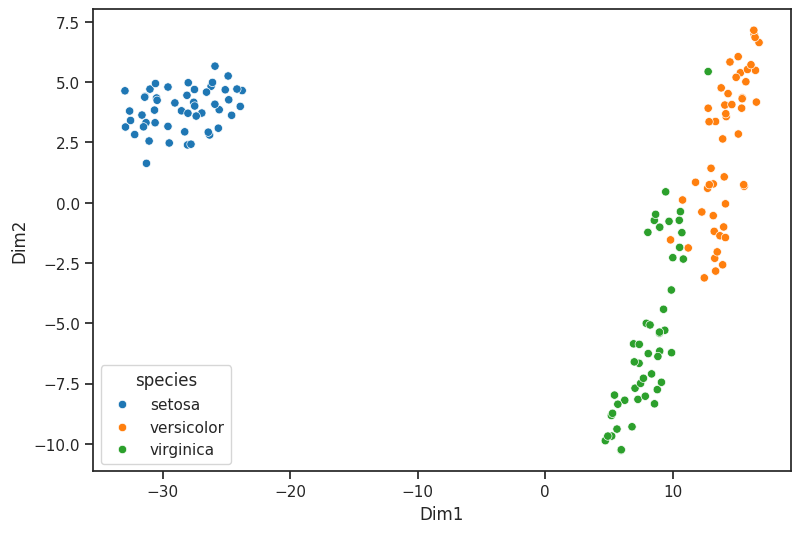

In [ ]:
sns.scatterplot(x='Dim1',y='Dim2', data=iris_tsne_df, hue=iris_target);

!!! keypoints "Key points"  
    - Unsupervised learning is an approach where we use machine
      learning to search for patterns in the data
    - Clustering can help you identify groups in your data